#Sistema de Recomendação

##Métodos

In [1]:
# Import da biblioteca

import pandas as pd
idx = pd.IndexSlice

from collections import Counter

In [2]:
# Preparando o Dataset

links = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/links.csv",  index_col=['movieId'])
movies = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/movies.csv", sep=",", index_col=['movieId'])
ratings = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/ratings.csv", index_col=['userId','movieId'])
tags = pd.read_csv("http://www.data2learning.com/repo/datasets/movielens/tags.csv", index_col=['userId','movieId'])

In [3]:
print("Total de usuários na base: %i" % len(list(set([x[0] for x in ratings.index.values]))))
print("Total de filmes: %i" % (movies.shape[0]))
print("Total de avaliações: %i" % (ratings.shape[0]))

Total de usuários na base: 610
Total de filmes: 9742
Total de avaliações: 100836


##Métodos do Professor

In [4]:
def get_movies_by_user(id_user, rating_cut=0, list_=False):
    
    """Retorna a lista de filmes avaliados por um usuário

    Keyword arguments:
    id_user -- id do usuário
    rating_cut -- retorna só itens avaliados com rating maior e igual que rating_cut (default: 0)
    list_ -- se True retorna somente os ids dos filmes, se False retorna os ids com o valor do rating (default: False)
    
    """

    
    return_dict = {}
    dict_ = ratings.loc[idx[id_user, :], 'rating'].T.to_dict()
    
    for d in dict_:
        if rating_cut != 0:
            if dict_[d] >= rating_cut:
                return_dict[d[1]] = dict_[d]
        else:
            return_dict[d[1]] = dict_[d]
    
    if list_:
        return list(return_dict.keys())

    return return_dict

def get_users_by_movie(id_movie, rating_cut=0, list_=False):
    
    """Retorna a lista de usuários que avaliaram determinado filme

    Keyword arguments:
    id_movie -- id do filme
    rating_cut -- retorna só usuários que avaliaram o filme com rating maior e igual que rating_cut (default: 0)
    list_ -- se True retorna somente os ids dos usuários, se False retorna os ids com o valor do rating
    
    """
    
    return_dict = {}

    try:
      dict_ = ratings.loc[idx[:, id_movie],'rating'].T.to_dict()

      for d in dict_:
        if rating_cut != 0:
            if dict_[d] >= rating_cut:
                return_dict[d[0]] = dict_[d]
        else:
            return_dict[d[0]] = dict_[d]
    
    except KeyError as e:
      pass
    
    
        
    if list_:
        return list(return_dict.keys())
    
    return return_dict

def get_rating_by_user_movie(id_user, id_movie):
    
    """Retorna o rating que o usuário (id_user) deu para um filme (id_movie). Se não existir, retorna 0.0.

    Keyword arguments:
    id_user -- id do usuário
    id_movie -- id do filme
    
    """
    
    rating = 0.0;
    
    try:
        rating = ratings.loc[idx[id_user, id_movie], 'rating']
    except KeyError as e:
        rating = 0.0

    return rating

def get_movie_title(id_movie):
    
    """Retorna o título de um filme.

    Keyword arguments:
    id_movie -- id do filme
    
    """
    
    info = movies.loc[idx[id_movie], :]
    return info['title']

def get_all_users(ratings_):
    
    """Retorna o id de todos os usuários.
    """
    
    return list(set([x[0] for x in ratings_.index.values]))

In [5]:
'''Neste trecho vamos armazenar em memória as informações de filmes avaliados pelos usuários. Isso evitar
   fazermos muitos acesso a estrutura do DataFrame. 
'''

all_users = get_all_users(ratings)

movies_user = {}

for user in all_users:
    movies_user[user] = get_movies_by_user(user, rating_cut=5, list_=True)

In [6]:
'''Neste trecho vamos armazenar em memória as informações de usuários que avaliaram determinado filme. Isso evitar
   fazermos muitos acesso a estrutura do DataFrame. 
'''

user_movies = {}

for movie in list(movies.index):
  user_movies[movie] = get_users_by_movie(movie, rating_cut=5, list_=True)

##Grafo

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for user in all_users:
  node_name = "User" + str(user)
  G.add_node(node_name)

for user in all_users:
  my_movies = movies_user[user]

  # Lista de todos os usuários que avaliaram os filmes assistidos por A
  all_users = []

  for movie in my_movies:
      all_users = all_users + user_movies[movie]

  all_users = list(set(all_users))
  
  for neigh in all_users:
    user_a = "User" + str(user)
    user_b = "User" + str(neigh)
    G.add_edge(user_a, user_b)

 

In [8]:
print("Total de vértices: %i" % G.number_of_nodes())
print("Total de arestas: %i" % G.number_of_edges())

Total de vértices: 610
Total de arestas: 62369


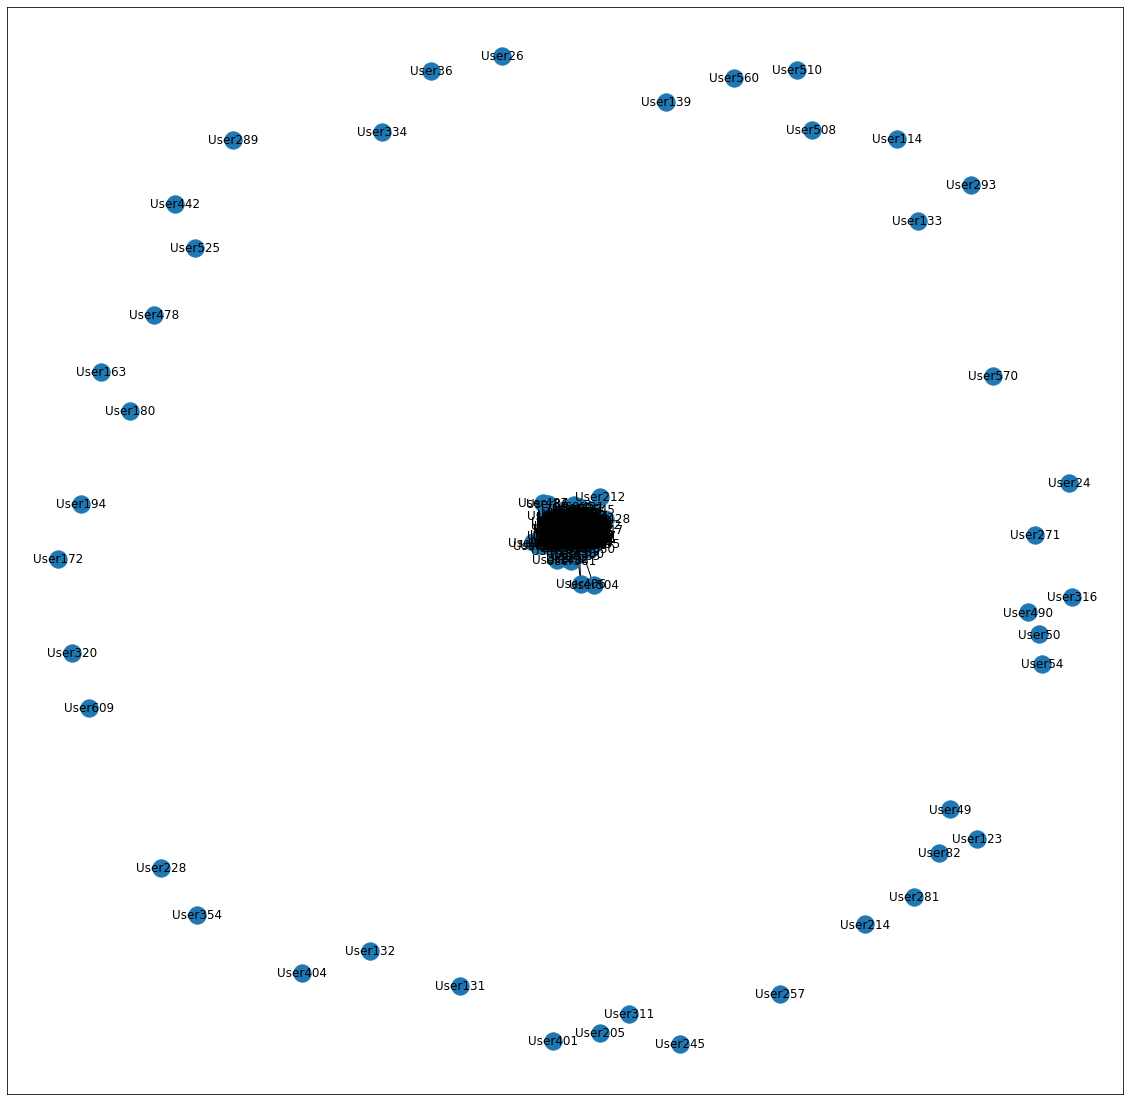

In [9]:
plt.figure(figsize=(20, 20))
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)
plt.show()

#Executar

##Recomendação

In [10]:
# Modelo do método que deve ser implementado
def recomendacao(user, G):
    """
    Retorna a lista de filmes recomendados dado um usuário e um grafo representativo da base

    Keyword arguments:
    user -- usuário
    id_movie -- Grafo na estrutura do NetworkX
    """

    filmes_adjacentes = []
    for user in G.adj[user]:
        filmes_adjacentes.append(get_movies_by_user(int(user[4]), rating_cut=5, list_=True))
    
    for movie in get_movies_by_user(int(user[4]), rating_cut=5, list_=True):
        for i in range(len(filmes_adjacentes)):
            if movie in filmes_adjacentes[i]:
                filmes_adjacentes[i].remove(movie)
    
    codigos = dict(sum(map(Counter, filmes_adjacentes), Counter()))

    recomendacoes = []
    for i in sorted(codigos, key = codigos.get, reverse=True):
        recomendacoes.append(i)
    
    list_of_movies_recommended = []

    for i in range(0, 10):
        list_of_movies_recommended.append(get_movie_title(recomendacoes[i]))
    
    return list_of_movies_recommended

In [11]:
#Executar

user = input("Digite o usuário: ")
print("\n")
for movie in recomendacao(user, G):
    print(movie)

Digite o usuário: User23


Road Warrior, The (Mad Max 2) (1981)
Schindler's List (1993)
Pinocchio (1940)
Tommy Boy (1995)
Tombstone (1993)
Ghost and the Darkness, The (1996)
Dances with Wolves (1990)
Beauty and the Beast (1991)
Escape from L.A. (1996)
Saturn 3 (1980)
